In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
from datetime import datetime
from IPython.display import HTML
from matplotlib import animation

# Ignore some warnings produced by basemap
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# try to import Basemap
try:
    from mpl_toolkits.basemap import Basemap
    has_basemap = True
except ImportError:
    has_basemap = False

# Set the map resolution
# Notice: set resolution to full will make this program time-consuming
map_resolution = "i" # l: low, i: intermediate, h: high, f: full
    
plt.rcParams['figure.figsize'] = (20,5) # fiqure size

# Dataset
Citibike 資料集，類似 Ubike 有固定的站點，每一筆代表一個租借紀錄。
- tripduration: 租借總時間
- starttime: 開始時間
- start_station_{id,name,latitude,longitude}: 起始車站的 id, 名稱 及 座標 (租借點)
- end_station_{id,name,latitude,longitude}: 終點車站的 id, 名稱 及 座標 (歸還點)
- stoptime: 結束時間

In [2]:
with open('201707-citibike-tripdata.csv', mode='r', encoding='utf-8') as file:
    trip_data = pd.read_csv(file, parse_dates=['starttime', 'stoptime'])
    trip_data.columns = trip_data.columns.str.replace('\s+', '_')

trip_data.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,364,2017-07-01 00:00:00,2017-07-01 00:06:05,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3107,Bedford Ave & Nassau Ave,40.723117,-73.952123,14744,Subscriber,1986.0,1
1,2142,2017-07-01 00:00:03,2017-07-01 00:35:46,293,Lafayette St & E 8 St,40.730207,-73.991026,3425,2 Ave & E 104 St,40.789210,-73.943708,19587,Subscriber,1981.0,1
2,328,2017-07-01 00:00:08,2017-07-01 00:05:37,3242,Schermerhorn St & Court St,40.691029,-73.991834,3397,Court St & Nelson St,40.676395,-73.998699,27937,Subscriber,1984.0,2
3,2530,2017-07-01 00:00:11,2017-07-01 00:42:22,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,398,Atlantic Ave & Furman St,40.691652,-73.999979,26066,Subscriber,1985.0,1
4,2534,2017-07-01 00:00:15,2017-07-01 00:42:29,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,398,Atlantic Ave & Furman St,40.691652,-73.999979,29408,Subscriber,1982.0,2


# 前處理
這次的 Lab ，我們要嘗試從空間及時間兩個角度，對這些車站做分群。

## 空間前處理 (經緯度)
將所有車站的經緯度輸出，因為可能有的車站只有輸入或是輸出，所以需要提取所有 start_stations 及 end_stations 後，再將兩者合併。

In [3]:


start_stations = trip_data[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()
start_stations.columns = ['station_id', 'name', 'latitude', 'longitude']

end_stations = trip_data[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates()
end_stations.columns = ['station_id', 'name', 'latitude', 'longitude']

#how = "outer"代表做Union
station_info = pd.merge(start_stations, end_stations, how = 'outer', on=['station_id', 'name', 'latitude', 'longitude']).sort_values(by='station_id').set_index('station_id')
station_info.head(5)


,name,latitude,longitude
station_id,,,
72,W 52 St & 11 Ave,40.767272,-73.993929
79,Franklin St & W Broadway,40.719116,-74.006667
82,St James Pl & Pearl St,40.711174,-74.000165
83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
116,W 17 St & 8 Ave,40.741776,-74.001497


## 時間前處理 (Inflow & Outflow)
這邊我們希望能針對每一個車站，得到他每個時段有多少借出以及歸還，也就是每一個車站會產生一個 time series 資料，每個時間點會有 inflow 及 outflow 的值。

In [4]:
# 建立空table
inout_flow = pd.DataFrame(0, index=station_info.index, columns=['time'])
inout_flow = pd.concat([inout_flow]*48*31)
inout_flow.sort_index(inplace=True)
inout_flow['time'] = np.tile(pd.date_range("2017-07-01 00:00", "2017-07-31 23:30", freq="30min"), len(station_info))

#outflow : 借出
#inflow : 歸還
# 求出每個station在time segments內的in, out flow count之table
in_flow_count = trip_data.groupby(['end_station_id', pd.Grouper(key='stoptime', freq='30Min')]).size().to_frame()
in_flow_count.reset_index(inplace=True)
in_flow_count.columns = ['station_id', 'time', 'in_flow_count']

out_flow_count = trip_data.groupby(['start_station_id', pd.Grouper(key='starttime', freq='30Min')]).size().to_frame()
out_flow_count.reset_index(inplace=True)
out_flow_count.columns = ['station_id', 'time', 'out_flow_count']

# join tables
inout_flow.reset_index(inplace=True)
inout_flow = pd.merge(inout_flow, in_flow_count, how = 'left', on=['station_id', 'time'])
inout_flow = pd.merge(inout_flow, out_flow_count, how = 'left', on=['station_id', 'time'])
inout_flow.fillna(0, inplace=True)
inout_flow.set_index('station_id', inplace=True)
inout_flow.head()



,time,in_flow_count,out_flow_count
station_id,,,
72,2017-07-01 00:00:00,1.0,0.0
72,2017-07-01 00:30:00,0.0,0.0
72,2017-07-01 01:00:00,2.0,1.0
72,2017-07-01 01:30:00,0.0,1.0
72,2017-07-01 02:00:00,0.0,0.0


# Spatial Clustering

定義繪地圖的函式

In [5]:
# 車站座標
def draw_map():
    if not has_basemap:
        return
    m = Basemap(resolution = map_resolution,llcrnrlon=-74.05,llcrnrlat=40.65,urcrnrlon=-73.9,urcrnrlat=40.81,lat_0=40.73,lon_0=-73.975,projection='lcc')
    m.drawcoastlines()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='white',lake_color='aqua')


coords = station_info.as_matrix(columns=['latitude', 'longitude'])

if has_basemap:
    m = Basemap(resolution = 'i',llcrnrlon=-74.05,llcrnrlat=40.65,urcrnrlon=-73.9,urcrnrlat=40.81,lat_0=40.73,lon_0=-73.975,projection='lcc')
    # 座標對應到畫的地圖上的位置
    x, y = m(coords[:, 1], coords[:, 0])
else:
    x, y = coords[:, 1], coords[:, 0]

## KMeans
繪製 K = 2, 4, 6, 8 的 KMeans 分群結果

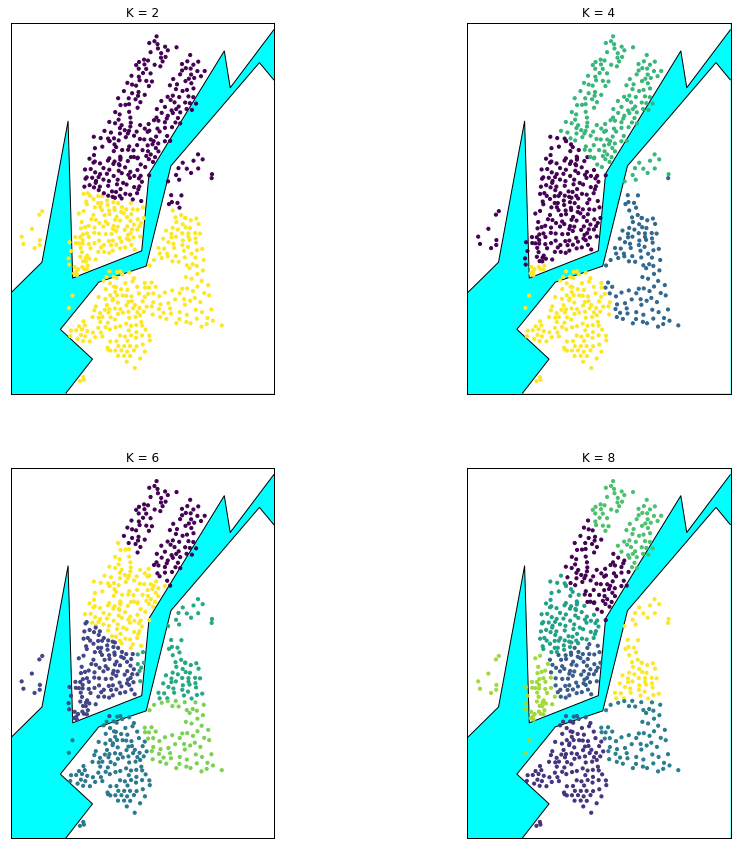

In [6]:
maxK = 10
fig = plt.figure(figsize=(15,15))
for i in range(2, 8 + 1, 2):
    plt.subplot(2, 2, int(i / 2))
    draw_map()
    plt.title('K = ' + str(i))
    kmeans = KMeans(n_clusters=i).fit(coords)
    plt.scatter(x, y, c=kmeans.labels_, zorder=3, s=10)

### Elbow Method
判斷分群結果好壞方法一

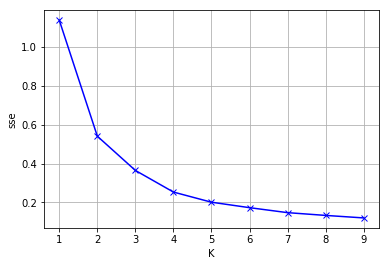

In [7]:
sse = {}
for k in range(1, maxK):
    kmeans = KMeans(n_clusters=k).fit(coords)
    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_
plt.plot(sse.keys(), sse.values(), 'bx-')
plt.xlabel('K')
plt.ylabel('sse')
plt.grid(True)
plt.show()

K = 2 時能有比較明顯的折角。

### Silhouette method
判斷分群結果好壞方法二

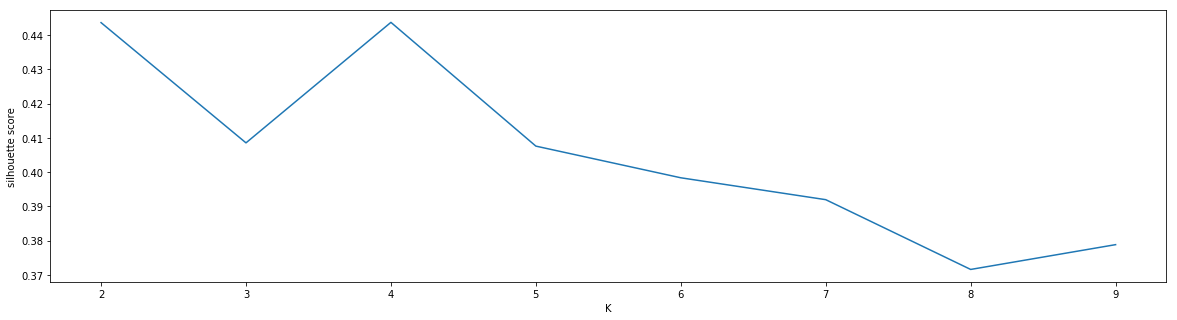

In [8]:
score = []

for k in range(2, maxK):
    kmeans = KMeans(n_clusters=k).fit(coords)
    score.append(metrics.silhouette_score(coords, kmeans.labels_))
    
fig = plt.figure(figsize=(20,5))
plt.xlabel('K')
plt.ylabel('silhouette score')
plt.plot(range(2, maxK), score)
plt.show()

#畫出來越高代表效果越好 : k = 2/4比較好



K = 2, 4 時效果比較好，但是根據繪製到地圖上的結果， K = 2 的結果並不太好，所以分群數目設定為 4 比較適合。

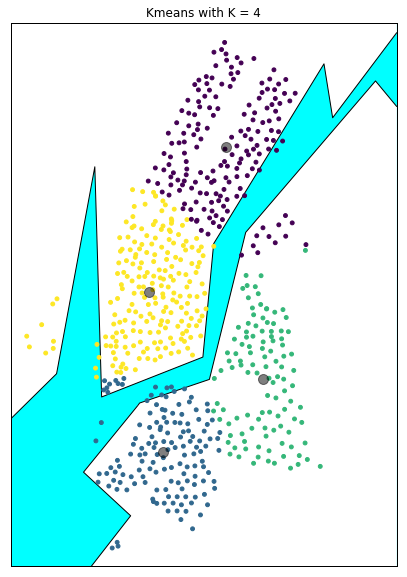

In [9]:
kmeans = KMeans(n_clusters=4).fit(coords)
fig = plt.figure(figsize=(10, 10))
draw_map()
plt.scatter(x, y, c=kmeans.labels_, s=15, zorder=3)

centers = kmeans.cluster_centers_
if has_basemap:
    centerX, centerY = m(centers[:, 1], centers[:, 0])
else:
    centerX, centerY = centers[:, 1], centers[:, 0]
plt.scatter(centerX, centerY, c='black', s=100, alpha=0.5, zorder=4),

plt.title('Kmeans with K = ' + str(4))
plt.show()

## DBSCAN
定義繪製 DBSCAN 結果的函式

In [10]:
# 假設分出三群 : label = 0, 1, 2, -1(Noise)
def plot_DBscan(db):
    labels = db.labels_
   
    sizes = [3 if l == -1 else 15 for l in db.labels_]
    plt.scatter(x, y, c=db.labels_, zorder=3, s=sizes)


### 固定eps，調整min_samples

metric 使用 haversine

eps設為0.005 (經多次嘗試得到比較能分出群來的大概數字，太大會全部分成同一群，太小又全部變outlier)
因為資料是經緯度，所以metric使用haversine，讓站與站之間的距離用大圓距離來算，才能反映真實情形。


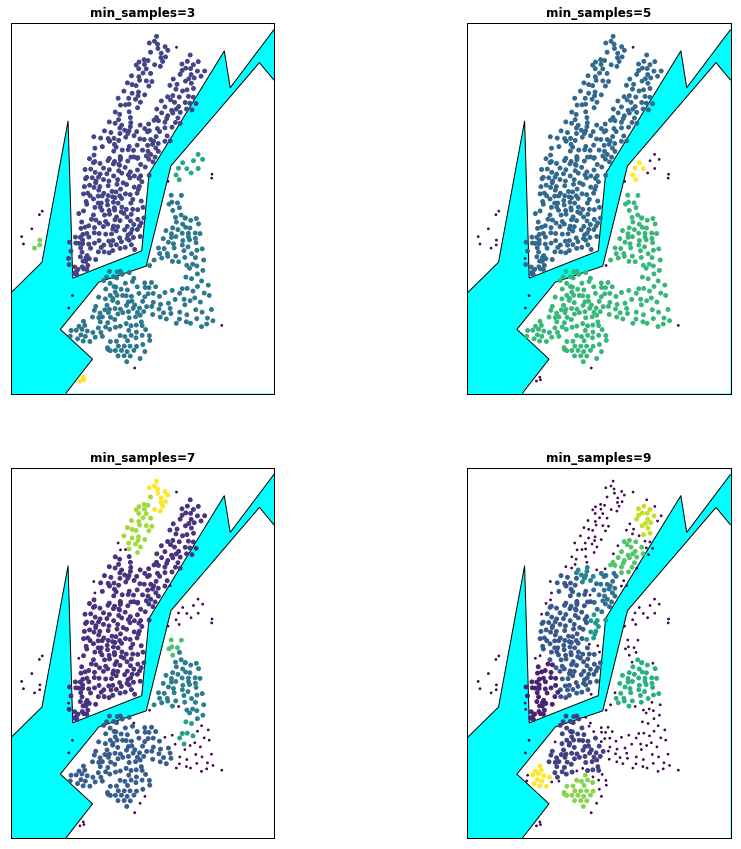

In [11]:
fig = plt.figure(figsize=(15,15))
fix_eps = 0.005
for min_sample in range(3, 9+1, 2):
    plt.subplot(2, 2, (min_sample - 1) / 2)
    draw_map()
    db = DBSCAN(eps=fix_eps, min_samples=min_sample, metric='haversine').fit(coords)

    plot_DBscan(db)
    plt.title('min_samples='+str(min_sample), fontweight='bold')    


### 固定 min_samples， eps =0.005~0.006
metric 使用 haversine, min_samples 設為 7


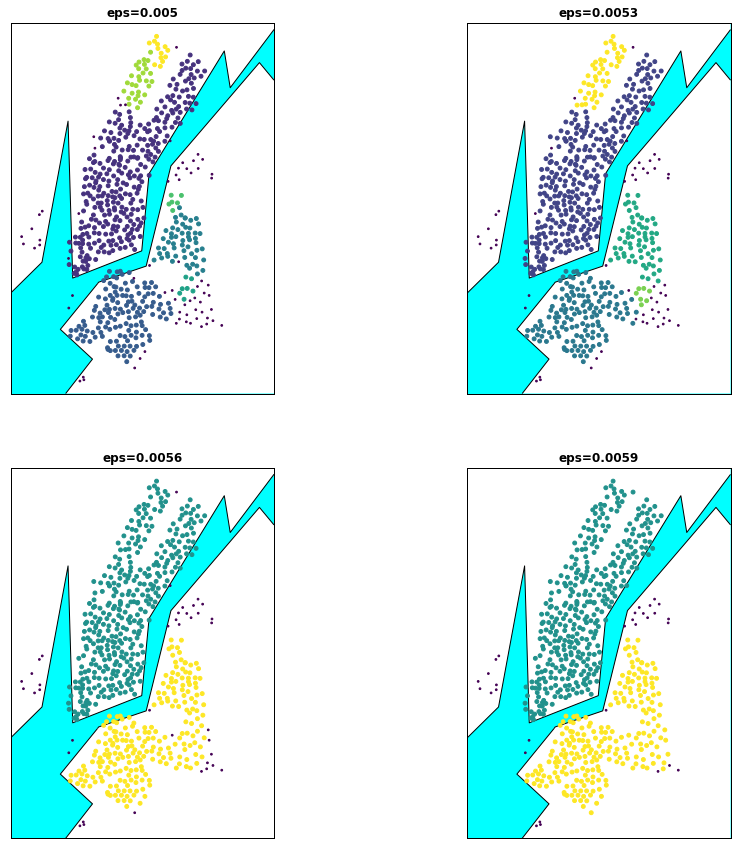

In [12]:
fix_min_samples = 7
eps_base = 5 * 1e-3
fig = plt.figure(figsize=(15, 15))

for eps in range(0, 9 + 1, 3):
    plt.subplot(2, 2, (eps + 3) / 3)
    eps = eps * 1e-4 + eps_base
    draw_map()
    db = DBSCAN(eps=eps, min_samples=fix_min_samples, metric='haversine').fit(coords)

    plot_DBscan(db)
    plt.title('eps='+str(eps), fontweight='bold')  

### 比較 metric 使用 haversine 和 euclidean

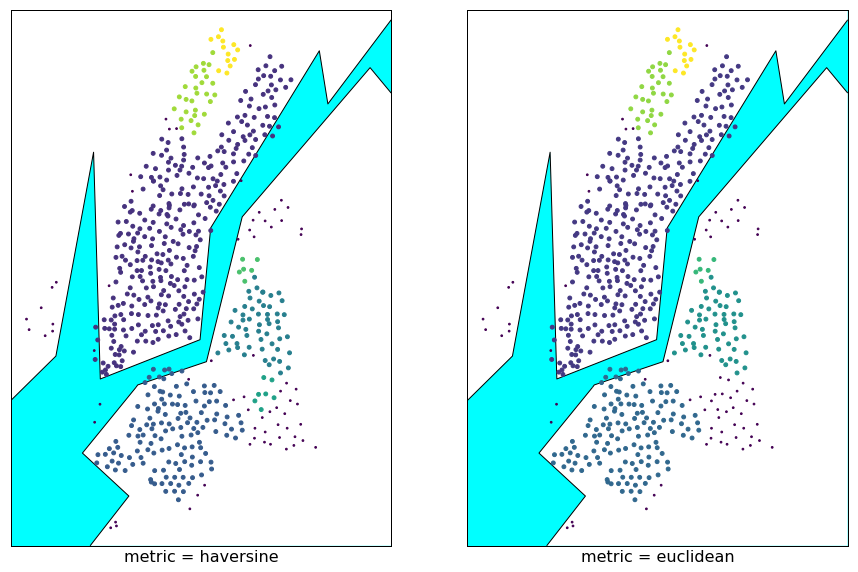

In [13]:
eps = 0.005
min_samples = 7

fig = plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
draw_map()
#haversine : 考慮到地球是個球型來計算距離
db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit(coords)
plt.xlabel('metric = haversine', fontsize=16)
plot_DBscan(db)

plt.subplot(1,2,2)
draw_map()
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(coords)
plt.xlabel('metric = euclidean', fontsize=16)
plot_DBscan(db)

plt.show()

## Conclusion
```
這份資料明顯有一條河切開了兩群，Kmeans 卻沒有辦法正確的找出結果，是因為 KMeans 算法計算的是所有點到群中心的距離，不利於處理狹長型的群，而 DBSCAN 因為是關注點與點之間個別的距離，當群之間有明確的界線時，就可能得到不錯的分類結果。
```

# Temporal Clustering
欲分群的資料：

每一筆資料為一個station"前五天"的in-flow及out-flow time series，共有480個點 (也就代表資料有 480 個維度)

分群的對象一樣是車站

In [14]:
weekflow_pd = inout_flow.loc[inout_flow['time'] < datetime(2017, 7, 6), ['in_flow_count', 'out_flow_count']]
weekflow = weekflow_pd.groupby(weekflow_pd.index).aggregate(lambda x: list(x)).sum(axis=1)
print(weekflow.head(5))
weekflow = weekflow.tolist()

station_id
72     [1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
79     [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
82     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
83     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
116    [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object


## Agglomerative Clustering
定義繪製 AgglomerativeClustering 結果的函式

In [15]:
def agg_cluster(n_clusters):
    fig = plt.figure(figsize=(15, 15))
    for index, metric in enumerate(["euclidean", "manhattan"]):
        model = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric, linkage="complete").fit(weekflow)
        plt.subplot(1,2,index+1)
        draw_map()
        plt.title("affinity = %s" % metric, size=20)
        plt.scatter(x, y, c=model.labels_, s=15, zorder=3)
    plt.suptitle("clustering number: %d" % n_clusters, size=20)
    plt.show()

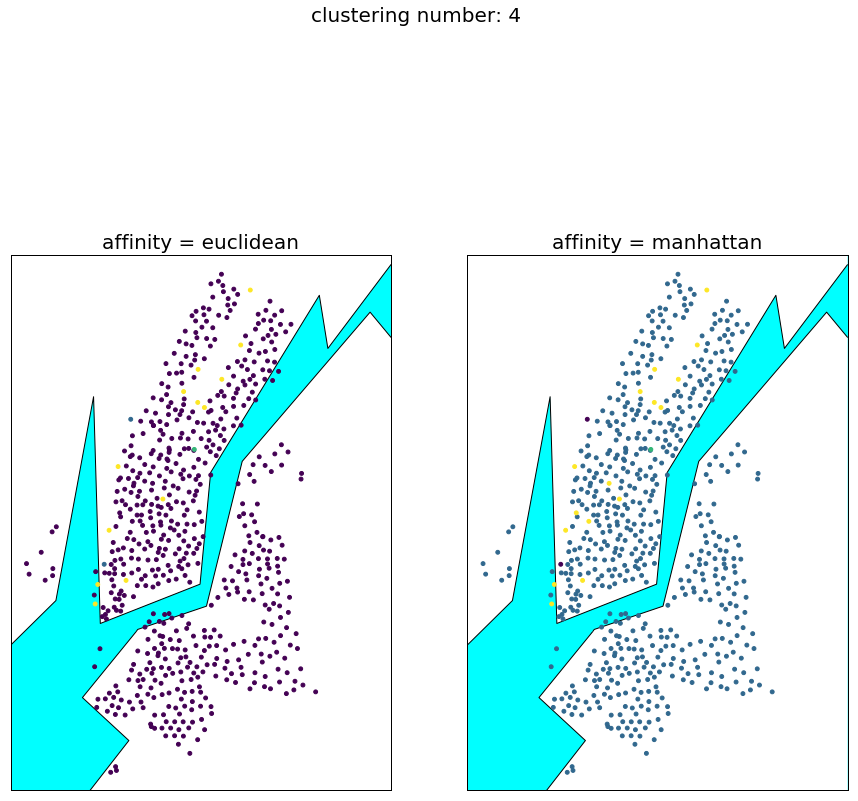

In [16]:
agg_cluster(4)

當分群數為4時，affinity 用 euclidean 和 manhattan 的分群結果幾乎沒什麼差別，且大多數的站均被分在同一群，推測是被部份租借狀況較為特殊的站點給影響了，可以嘗試增加 cluster 數目。

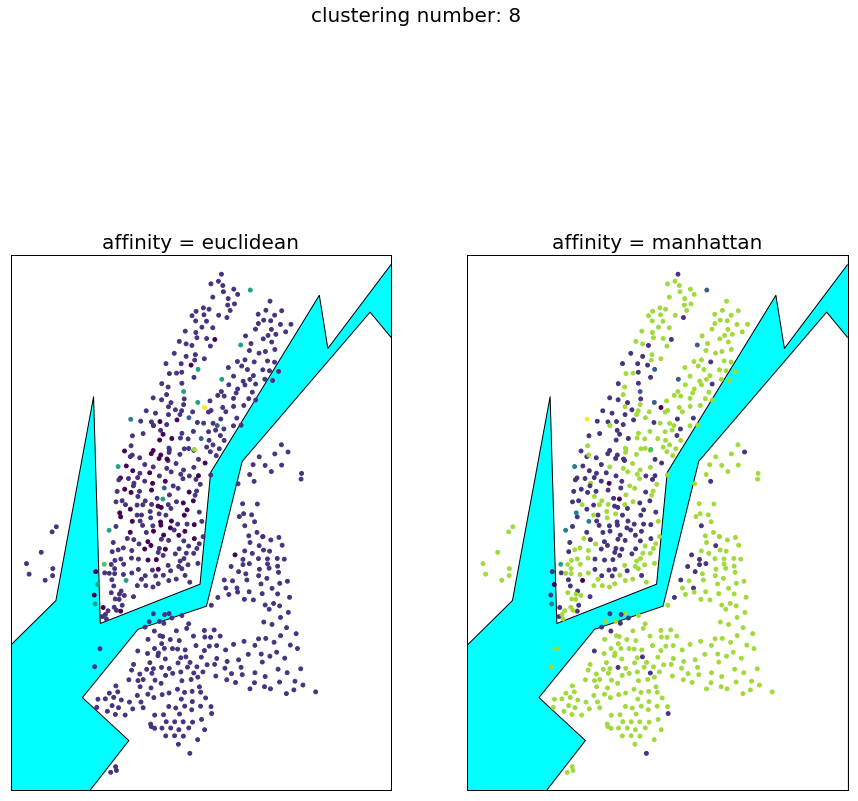

In [17]:
agg_cluster(8)


```
這時候我們發現 Manhattan 法明顯將資料分成了兩群，而 Euclidean 則沒有，可能是 Manhattan 會增加資料間的差異性導致了這個差異，且時間資料不像空間資料使用 Euclidean 時能代表實際的距離，所以在這個情形下， Manhattan 會是比較合理的作法。

觀察 Manhattan 的分群結果，其中一群比較集中在地圖中間的位置，比對 Google Maps 的結果，會發現該位置為曼哈頓下、中城，這兩個地區包含了華爾街等重要金融區，為曼哈頓島最繁華的地區。而另一群分佈在地圖的上半部及下右半部，上半部為上西城及上東城，屬於住宅區，而下又半部的地區也不屬於商辦區。這兩群的人流情況有明顯的差異，而租借狀況也顯然會受到人流情形影響，導致了這樣的分群結果。
```

In [18]:
#因為資料點之間是時間的關係, 用Euclidean去計算距離不太合理

## PCA

In [19]:
#主成份分析, 找出變異度最大的當做第一主成份, 第二主成份是與第一主成份垂直並且變異度最大的, 第三主成份與第一和第二主成份垂直並且變異度最大...
#可以透過把變異度較小的成分濾除(不太重要的維度)來達成降維

In [20]:
n_clusters=8

def pca_agg(n_components):
    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

    fig = plt.figure(figsize=(15, 15))

    pca = PCA(n_components=n_components, svd_solver='full')
    flow_pca = pca.fit_transform(weekflow)
    flow_new = pca.inverse_transform(flow_pca)

    plt.subplot(1,2,1)
    draw_map()
    start_time = time.time()
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity="manhattan", linkage="complete").fit(weekflow)
    time_cost = time.time() - start_time
    plt.xlabel("time: %.3f seconds" % time_cost, size=18)
    # plt.title("origin \n silhouette score: %.3f" 
    #          % metrics.silhouette_score(weekflow, model.labels_), size=20)
    label_color = [color[i] for i in model.labels_]
    plt.scatter(x, y, c=label_color, s=15, zorder=3)

    plt.subplot(1,2,2)
    draw_map()
    start_time = time.time()
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity="manhattan", linkage="complete").fit(flow_new)
    time_cost = time.time() - start_time
    plt.xlabel("time: %.3f seconds" % time_cost, size=18)
    
    # plt.title("PCA n_components = %d \n silhouette score: %.3f" 
    #          % (pca.n_components_, metrics.silhouette_score(weekflow, model.labels_)), size=20)
    label_color = [color[i] for i in model.labels_]
    plt.scatter(x, y, c=label_color, s=15, zorder=3)

    plt.show()
    print("Explained Variance Ratio:", sum(pca.explained_variance_ratio_))

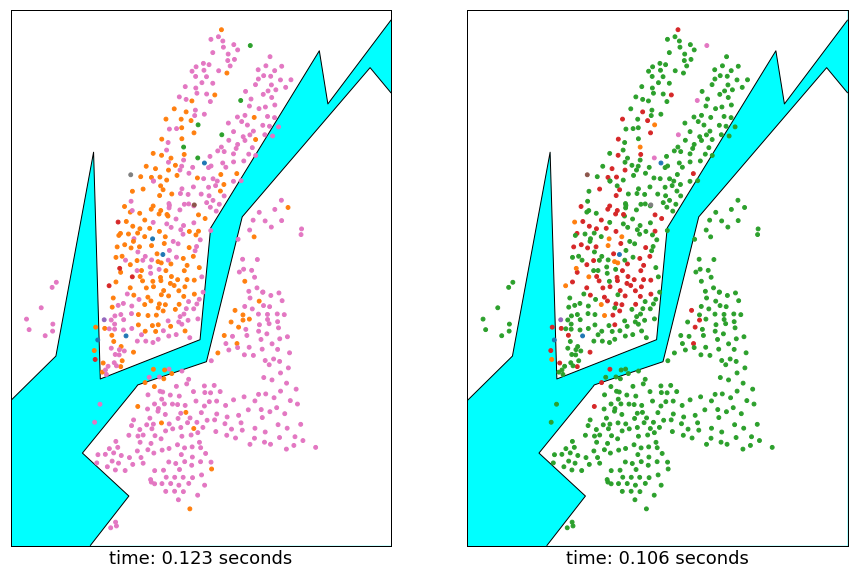

Explained Variance Ratio: 0.9673769312720081


In [21]:
pca_agg(200)

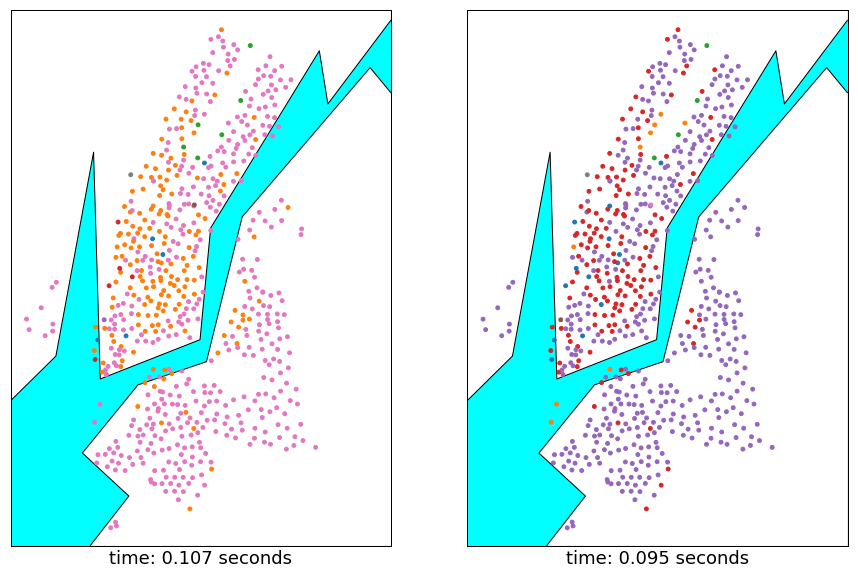

Explained Variance Ratio: 0.8830190443895221


In [22]:
pca_agg(100)

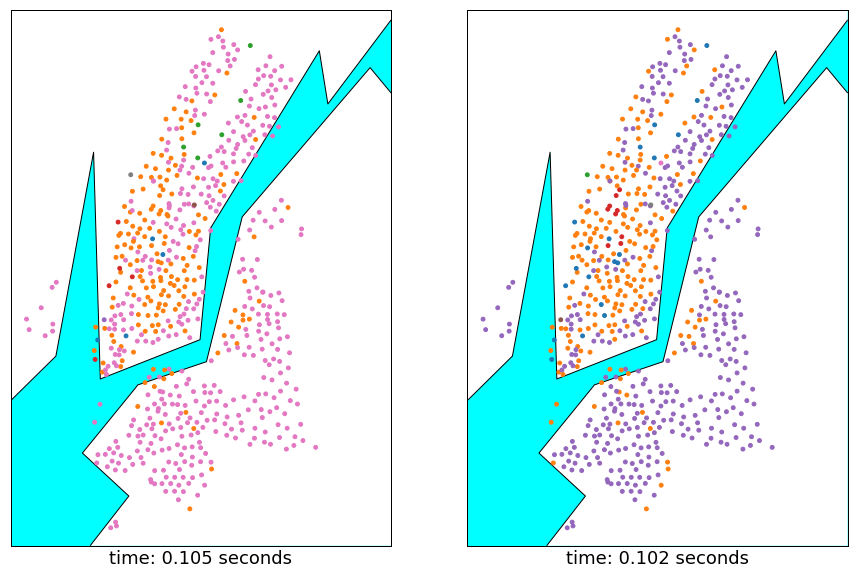

Explained Variance Ratio: 0.6330988080241203


In [23]:
pca_agg(10)

PCA 可以用來減少資料的維度，功能為 denoise 或是減少後續的程式執行時間，從結果來看，使用 PCA 將資料降到 200　維之後，還能夠有 0.967 的解釋能力，逐漸降低維度至 10 後，也仍然有 0.633 的解釋力，分群的結果看起來也與原本的相似，代表說就算將模型縮減到剩下 10 維度，仍然能分出合理的群。